In [1]:
# understand system and version
#import sys
#print(sys.version)
#!jupyter kernelspec list
#import pdb


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# Here's several helpful packages to load
#import sys
#print(sys.version)
#import pdb

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os  # use OS dependent functions like reading or writing files
os.environ['NUMEXPR_MAX_THREADS'] = '10' # default is 8, Mac Book M1 Pro has 10 can support 10, which may slow down the computer
import re  # regular expressions in Python for searching patterns

import math

import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn as nn  # base class for all neural network modules in PyTorch
from glob import glob  # find all the pathnames matching a specified pattern according to the rules used by the Unix shell
from matplotlib import pyplot as plt # plot libary
import collections # build-in types
from tqdm import tqdm # provides a progress bar for loops and iterators
from itertools import chain # provides iterations 
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction # Natural Language Toolkit (nltk)

import matplotlib.pyplot as plt # for analyze dataset

import spacy # determine if a sentence is grammatically correct.

# MI related dependence
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.feature_selection import mutual_info_regression

# utils
from torch.utils.data import Dataset


# Config

In [3]:
class Config:
    train_test_ratio = 0.9 # the proportion of data that will be used for training versus testing
    E = 128
    V = 128
    L = None
    N = None
    # use the content of the decoder's first dimension (=V) as three transformer decoder's first part of input
    # channel: AWGN
    sigma = 3  #standard deviation of the Additive White Gaussian Noise (AWGN)
    loss_lambda = 1 # a weighting factor for the loss function
    clipping_max = 1.  # a threshold for clipping the gradients during training
    num_steps = 40 # number of steps for the training process
CONFIG = Config()

# Preprocess

# vocab

In [4]:
class Vocab:  
#   text vocabulary
    # __init__ sorts the tokens by frequency in descending order, and assigns an index to each token
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None): 
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = tokens
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],  
                                   reverse=True)            # A list of tokens sorted by frequency
        # Unknown tokens have an index of 0
        self.idx_to_token = ['<unk>'] + reserved_tokens  # List, idx corresponds to the position of token
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self): # returns the length of the vocabulary
        return len(self.idx_to_token)

    def __getitem__(self, tokens): # returns the index of a given token
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices): # returns the token corresponding to a given index
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Unknown tokens have an index of 0
        return 0

    @property
    def token_freqs(self): # returns the list of token frequencies that was sorted in descending order during initialization of the Vocab class.
        return self._token_freqs

def count_corpus(tokens):  
    """Count the frequency of words"""
    # The tokens here are 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flattens a list of tokens into a list
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [5]:
vocab_list = open('./corpus_train_vocab.txt').readlines() 
vocab_dict = {}  # create an empty dictionary
for key_value_pair in vocab_list:
    key_value_pair = key_value_pair.strip().split()
    vocab_dict[key_value_pair[0]] = int(key_value_pair[1]) # in the vocabulary list, key is token and value is the frequency
source_vocab = Vocab(collections.Counter(vocab_dict), reserved_tokens=['<pad>', '<eos>', '<bos>'])

# dataset

In [6]:
train_corpus = open('./corpus_train_split.txt', 'r').readlines()  # the special "\n" has not been processed

class EuroParlDataset(torch.utils.data.Dataset):  # define Pytorch data set
    def __init__(self, vocab=source_vocab, corpus=train_corpus):
        self.vocab = vocab
        self.corpus = corpus
        
    def __len__(self):
        return len(self.corpus)
    
    def __getitem__(self, index):
        sentence = self.corpus[index].strip().split() + ['<eos>']
        return self.vocab[sentence], len(sentence)
    
# collate_fn combines a list of samples into a single batch：
# sorts the batch data by the length of the sentence, in descending order;
# extracts the length of the sentences, and converts the sentences into tensors;
# pads the tensors to the maximum length of the sentences in the batch.
def collate_fn(batch_data): 
    batch_data.sort(key=lambda xi: len(xi[0]), reverse=True)
    data_length = [xi[1] for xi in batch_data]
    data = [torch.tensor(xi[0]) for xi in batch_data]
    padded_data = nn.utils.rnn.pad_sequence(data, batch_first=True, padding_value=1)
    return padded_data, torch.tensor(data_length)

# loads the text data from corpus_train_split.txt and converts it into numerical representations using the vocabulary, with the <eos> token appended to each sentence. 
# Then the dataset is loaded in batches of 32, shuffled, and padded to the maximum length of the sentence in each batch.
data_loader = torch.utils.data.DataLoader(dataset=EuroParlDataset(), batch_size=32, shuffle=True, collate_fn=collate_fn)

# pipeline

In [7]:
# The system  uses nn.embedding
# L E V N setup: E=128， V=128

# backbone

In [8]:
torch.set_printoptions(threshold=np.inf)
# MI needs to be masked; mask first and then sample
# decoder needs to be masked
# phase=2 needs chain
class PositionalEncoding(nn.Module):
    """position encoding"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

class MyEmbedding(nn.Module):
    def __init__(self, vocab=source_vocab):
        super(MyEmbedding, self).__init__()
        self.embedding = nn.Embedding(len(vocab), CONFIG.E, padding_idx=vocab['<pad>'])
        
    def forward(self, X):
        return self.embedding(X)
    
class Encoder(nn.Module):
    def __init__(self, vocab=source_vocab):
        super(Encoder, self).__init__()
        self.position_encoding = PositionalEncoding(CONFIG.V, dropout=0.1)
        self.transformer_encoder1 = nn.TransformerEncoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.transformer_encoder2 = nn.TransformerEncoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.transformer_encoder3 = nn.TransformerEncoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.linear1 = nn.Linear(CONFIG.V, 2 * CONFIG.V)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(2 * CONFIG.V, 16)
        self.relu2 = nn.ReLU()
        
    def forward(self, X, valid_lens):
        mask = (torch.arange((X.shape[1]), device=device).unsqueeze(0) >= valid_lens.unsqueeze(1)).to(device)
        X2 = self.position_encoding(X)
        X3 = self.transformer_encoder1(X2, src_key_padding_mask=mask)
        X4 = self.transformer_encoder2(X3, src_key_padding_mask=mask)
        X5 = self.transformer_encoder3(X4, src_key_padding_mask=mask)
        X6 = self.linear1(X5)
        X7 = self.relu1(X6)
        X8 = self.linear2(X7)
        X9 = self.relu2(X8)
        return X9
        
def Channel(X):  # AWGN
    return X + torch.normal(0, CONFIG.sigma, size=X.shape).to(device)
        
class Decoder(nn.Module):
    def __init__(self, vocab=source_vocab):
        super(Decoder, self).__init__()
        # reshape
        self.position_encoding = PositionalEncoding(CONFIG.V, dropout=0.1)
        self.linear1 = nn.Linear(16, 2 * CONFIG.V)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(2 * CONFIG.V, CONFIG.V)
        self.relu2 = nn.ReLU()
        self.transformer_decoder1 = nn.TransformerDecoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.transformer_decoder2 = nn.TransformerDecoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.transformer_decoder3 = nn.TransformerDecoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.linear3 = nn.Linear(CONFIG.V, len(source_vocab))
#         self.softmax = nn.Softmax(dim=2)  # ?
        
    def forward(self, emb_decoder_input, channel_output, origin_len, tgt_mask=None, mode='train'):
        memory_mask = (torch.arange((channel_output.shape[1]), dtype=torch.float32,
                            device=device)[None, :] >= origin_len[:, None]).to(device)
        channel_output = self.linear1(channel_output)
        channel_output = self.relu1(channel_output)
        channel_output = self.linear2(channel_output)
        memory = self.relu2(channel_output)
        emb_decoder_input = self.position_encoding(emb_decoder_input)
        X6 = self.transformer_decoder1(emb_decoder_input, memory, tgt_mask=tgt_mask, memory_key_padding_mask=memory_mask, tgt_key_padding_mask=memory_mask if mode == 'train' else None)
        X7 = self.transformer_decoder2(X6, memory, tgt_mask=tgt_mask, memory_key_padding_mask=memory_mask, tgt_key_padding_mask=memory_mask if mode == 'train' else None)
        X8 = self.transformer_decoder3(X7, memory, tgt_mask=tgt_mask, memory_key_padding_mask=memory_mask, tgt_key_padding_mask=memory_mask if mode == 'train' else None)
        X9 = self.linear3(X8)
#        X9 = self.softmax(X9, dim=-1)
        return X9
#         return self.softmax(X9)

class GlorotFanInInitializer(nn.Module):
    def __init__(self):
        super().__init__()

    def reset_parameters(self, module):
        for name, param in module.named_parameters():
            if 'weight' in name and len(param.shape) > 1:
                nn.init.xavier_uniform_(param, gain=nn.init.calculate_gain('relu') * math.sqrt(2.0 / (param.shape[0] + param.shape[1])))
    
class DeepST(nn.Module):
    def __init__(self):
        super(DeepST, self).__init__()
        self.encoder = Encoder()
        self.channel = Channel
        self.decoder = Decoder()
    
    #def _reset_parameters(self):
    #    for p in self.parameters():
    #        if p.dim() > 1:
    #            nn.init.xavier_uniform(p)
    

        
    def forward(self, emb_encoder_input, valid_lens, emb_decoder_input=None, embedding=None, phase=1):  # valid_lens includes <eos>
        '''
        x: (batch_size, N, E)
        '''
        encode_result = self.encoder(emb_encoder_input, valid_lens)
        channel_outputs = self.channel(encode_result)
#        outputs = self.decoder(channel_outputs, valid_lens) #
        if phase == 2:
            mask = (torch.triu(torch.ones(emb_decoder_input.shape[1], emb_decoder_input.shape[1])) == 1).transpose(0, 1)
            mask = (mask.masked_fill(mask == 0, True).masked_fill(mask == 1, False)).to(device)
            return encode_result, self.channel(encode_result), \
                   self.decoder(torch.cat([embedding(torch.full([emb_decoder_input.shape[0], 1], source_vocab['<bos>'], dtype=torch.long, device=device)), 
                                        emb_decoder_input[:, :-1, :]], dim=1).to(device), 
                                channel_outputs,
                                valid_lens, 
                                mask)
        else:
            return encode_result, self.channel(encode_result)

In [9]:
class MI(nn.Module):
    def __init__(self): #6 layers
        super(MI, self).__init__()
        self.linear1 = nn.Linear(16 * 2, 8 * CONFIG.V)
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(8 * CONFIG.V, 4 * CONFIG.V)
        self.relu2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(p=0.5)
        self.linear3 = nn.Linear(4 * CONFIG.V, 2 * CONFIG.V)
        self.relu3 = nn.ReLU()
        #self.dropout3 = nn.Dropout(p=0.5)
        self.linear4 = nn.Linear(2 * CONFIG.V, 2 * CONFIG.V)
        self.relu4 = nn.ReLU()
        #self.dropout4 = nn.Dropout(p=0.5)
        self.linear5 = nn.Linear(2 * CONFIG.V, 2 * CONFIG.V)
        self.relu5 = nn.ReLU()
        #self.dropout5 = nn.Dropout(p=0.5)
        self.linear6 = nn.Linear(2 * CONFIG.V, 1)
        self.relu6 = nn.ReLU()
        
    def network(self, X, Y):
        x = self.relu1(self.linear1(torch.cat([X, Y], dim=1)))
        #x = self.dropout1(x)
        x = self.relu2(self.linear2(x))
        #x = self.dropout2(x)
        x = self.relu3(self.linear3(x))
        #x = self.dropout3(x)
        x = self.relu4(self.linear4(x))
        #x = self.dropout4(x)
        x = self.relu5(self.linear5(x))
        #x = self.dropout5(x)
        x = self.relu6(self.linear6(x))
        return x
        
    def forward(self, X, Y, valid_lens): 
        
        mask = (torch.arange((X.shape[1]), dtype=torch.long,
                            device=X.device)[None, :] >= valid_lens[:, None]).reshape(-1)
        # Reshape X and Y first, then take them out
        X = X.reshape(-1, 16)
        Y = Y.reshape(-1, 16)
        
        X = X[mask == False]
        Y = Y[mask == False]
        
        # sample
        sample_size = X.shape[0]
        idx = list(range(sample_size))
        random.shuffle(idx)
        idx = torch.tensor(idx).to(device)
        X = X[idx]
        Y = Y[idx]
        idx_shuffle = list(range(sample_size))
        random.shuffle(idx_shuffle)
        idx_shuffle = torch.tensor(idx_shuffle).to(device)
        shuffle_Y = Y[idx_shuffle]
        
        output_joint = self.network(X, Y)
        output_marginal = self.network(X, shuffle_Y)
        
        return output_joint, output_marginal

# loss

In [10]:

def mi_criterion(x, y):
    max_y = torch.max(y)
    return torch.mean(x) - (max_y + torch.log(torch.mean(torch.exp(y - max_y))))

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def sequence_mask(self, X, valid_len, value=0):
        """
        Mask out irrelevant items in a sequence
        X: (batch_size, maxlen)
        """
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X
    
    """Softmax cross-entropy loss function with masking"""
    # pred's shape：(batch_size,num_steps,vocab_size)
    # label's shape：(batch_size,num_steps)
    # valid_len's shape：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = self.sequence_mask(weights, valid_len)
        self.reduction='mean'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [11]:
embedding = MyEmbedding()
embedding.to(device)
model = DeepST()
initializer = GlorotFanInInitializer()
model.apply(initializer.reset_parameters)
model.to(device)
mi_model = MI()
mi_model.to(device)

MI(
  (linear1): Linear(in_features=32, out_features=1024, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (relu3): ReLU()
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (relu4): ReLU()
  (linear5): Linear(in_features=256, out_features=256, bias=True)
  (relu5): ReLU()
  (linear6): Linear(in_features=256, out_features=1, bias=True)
  (relu6): ReLU()
)

# train

In [12]:
batch_total_loss_list, batch_mi_loss_list = [], []
epoch_total_loss_list, epoch_mi_loss_list = [], []

In [13]:
'''This is a training script for a model that includes two phases. In the first phase, 
the model optimizes the mutual information (MI) loss using the Adam optimizer.
The script initializes the mutual information (MI) model and optimizer, and applies 
the Kaiming uniform initialization to the model's weights. It then trains the model for 20 epochs, 
where in each epoch it iterates through the data loader and calculates the MI loss using the MI criterion. 
The gradients are then calculated, clipped to a certain value using torch.nn.utils.clip_grad_norm_ 
and the optimizer steps to update the model's parameters. It also keeps track of the running MI loss, 
and the batch and epoch MI loss, which are plotted at various points during training to visualize the loss.

In the second phase of training, the script initializes the optimizer for both the model and the embedding layer. 
It also sets the model to train mode. It then trains the model for 15 epochs, where in each epoch it iterates 
through the data loader and calculates the transceiver loss using the criterion and passing the input through 
the model and the embedding layer. The gradients are then calculated, clipped to a certain value using 
torch.nn.utils.clip_grad_norm_ and the optimizer steps to update the model's parameters and the embedding 
layer's parameters. It also keeps track of the running total loss, and the batch and epoch total loss, 
which are plotted at various points during training to visualize the loss.

It is also worth noting that the script is using the MaskedSoftmaxCELoss as the criterion, this loss is a 
variation of the softmax cross-entropy loss, but it takes into account the padding of the input sequence 
and masks the loss for the padded values so that they do not contribute to the loss calculation.
'''
# valid_lens has eos but not bos
def train(model=model, clipping_max=CONFIG.clipping_max, num_steps=CONFIG.num_steps, phase=1):
    
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_uniform_(m.weight)
    
    criterion = MaskedSoftmaxCELoss()
    
    # Generates data by sampling from two correlated Gaussian variables
    
    if phase == 1:
        mi_optimizer = torch.optim.Adam(mi_model.parameters(), lr=5e-5)
        mi_model.apply(init_weights)
        for epoch in range(15):
            running_mi_loss = 0.
            batch_cnt = 0
            batch_num = len(data_loader)
            for index, data in enumerate(tqdm(data_loader), 0):
                # phase == 1
                mi_optimizer.zero_grad()
                inputs, valid_lens = data
                inputs, valid_lens = inputs.to(device), valid_lens.to(device)
                emb_inputs = embedding(inputs)
                encode_outputs, channel_outputs = model(emb_inputs, valid_lens, phase=1)
                x, y = mi_model(encode_outputs, channel_outputs, valid_lens)
                mi_loss = -mi_criterion(x, y)
                mi_loss.backward()
                torch.nn.utils.clip_grad_norm_(mi_model.parameters(), clipping_max)
                mi_optimizer.step()
                running_mi_loss += float(mi_loss.data)
                batch_mi_loss_list.append(float(mi_loss.data))
                if batch_cnt > batch_num / 5:
                    print(f'now batch:{index} in epoch {epoch}')
                    batch_cnt = 0
                    plt.plot(batch_mi_loss_list)
                    plt.title('batch_mi_loss_list')
                    plt.show()
                batch_cnt += 1
                
            
            with torch.no_grad():
                print('===' * 10, 'epoch:', epoch, 'loss:', running_mi_loss)
                epoch_mi_loss_list.append(running_mi_loss)
                plt.plot(epoch_mi_loss_list)
                plt.title('epoch_mi_loss_list')
                plt.show()
    else:
        optimizer = torch.optim.Adam(chain(embedding.parameters(), model.parameters()), lr=1e-3)
        embedding_optimizer = torch.optim.Adam(embedding.parameters(), lr=1e-3) #

        #model.apply(init_weights)
        val_bleus = []
        for epoch in range(30):
            running_total_loss, running_mi_loss = 0., 0.  # initialize loss
            model.train()
            embedding.train() #
            batch_cnt = 0
            batch_num = len(data_loader)
            
            for index, data in enumerate(tqdm(data_loader), 0):
                # phase == 2
                optimizer.zero_grad()
                embedding_optimizer.zero_grad() #
                inputs, valid_lens = data
                inputs, valid_lens = inputs.to(device), valid_lens.to(device)
                emb_inputs = embedding(inputs)
                encode_outputs, channel_outputs, outputs = model(emb_inputs, valid_lens, emb_inputs, embedding, phase=2)

                x, y = mi_model(encode_outputs, channel_outputs, valid_lens)
                mi_loss = -mi_criterion(x, y)
                if batch_cnt % 5000 == 4999:
                    print(f'sample:{source_vocab.to_tokens(inputs[0, :valid_lens[0], :])}->{source_vocab.to_tokens(outputs[0, :valid_lens[0], :].argmax(dim=1))}')
                transceiver_loss = criterion(outputs, inputs, valid_lens).mean()
                total_loss = transceiver_loss + CONFIG.loss_lambda * mi_loss
#                total_loss = transceiver_loss
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(chain(embedding.parameters(), model.parameters()), clipping_max)
                optimizer.step()
                running_total_loss += float(total_loss.data)
                running_mi_loss += float(mi_loss.data)
                batch_total_loss_list.append(float(total_loss.data))
                batch_mi_loss_list.append(float(mi_loss.data))            

                batch_cnt += 1
                if batch_cnt > batch_num / 5:
                    print(f'now batch:{index} in epoch {epoch}')
                    batch_cnt = 0
                    plt.plot(batch_mi_loss_list)
                    plt.title('batch_mi_loss_list')
                    plt.show()
                    plt.plot(batch_total_loss_list)
                    plt.title('batch_total_loss_list')
                    plt.show()

            print('===' * 10, 'epoch:', epoch, 'loss:', running_total_loss)
            try:
                print('train sample:')
                for i in range(5):
                    print('********************\n',source_vocab.to_tokens(list(inputs[i].cpu().numpy())), '\n->\n', source_vocab.to_tokens(list(outputs[i, :].detach().cpu().argmax(dim=1).numpy())))
                
            except:
                pass
            
            epoch_total_loss_list.append(running_total_loss)
            epoch_mi_loss_list.append(running_mi_loss)
            plt.plot(epoch_total_loss_list)
            plt.title('epoch_total_loss_list')
            plt.show()
            plt.plot(epoch_mi_loss_list)
            plt.title('epoch_mi_loss_list')
            plt.show()
            
            if epoch <= 1 or epoch_total_loss_list[-1] < epoch_total_loss_list[-2]:
                torch.save(model.state_dict(), 'model.pth')
                torch.save(embedding.state_dict(), 'embedding.pth')
    
            with torch.no_grad():
                model.eval()
                bleus = []
                val_corpus = open('./corpus_val_split.txt', 'r').readlines()
                val_data_loader = torch.utils.data.DataLoader(dataset=EuroParlDataset(corpus=val_corpus), batch_size=32, shuffle=True, collate_fn=collate_fn)
                for index, data in enumerate(tqdm(val_data_loader), 0):
                    inputs, valid_lens = data
                    inputs, valid_lens = inputs.to(device), valid_lens.to(device)
                    emb_inputs = embedding(inputs)
                    _, channel_outputs = model(emb_inputs, valid_lens, phase=1)
                    # decoder's first one is <bos>
                    outputs = torch.cat([torch.full([inputs.shape[0], 1], source_vocab['<bos>'], dtype=torch.long, device=device), 
                                         torch.full([inputs.shape[0], num_steps - 1], source_vocab['<pad>'], dtype=torch.long, device=device)], 
                                        dim=1).to(device)

                    # continue_idx marks which sentences can continue to be generated
                    continue_idx = torch.arange(inputs.shape[0], device=device)
                    num_step = 0
                    while not len(continue_idx) == 0 and num_step < num_steps - 1:
                        emb_outputs = embedding(outputs[continue_idx, :num_step + 1])
                        pred_words = model.decoder(emb_outputs, channel_outputs[continue_idx], valid_lens[continue_idx], mode='validate').argmax(dim=2)[:, -1:]
#                        outputs[continue_idx] = pred_words.squeeze(1)
                        outputs[continue_idx, num_step + 1] = pred_words.squeeze(1)
                        continue_idx = continue_idx[(pred_words != source_vocab['<eos>']).squeeze(1)]
                        num_step += 1
                    for i in range(inputs.shape[0]):
                        bleus.append(sentence_bleu([list(inputs[i].cpu().numpy())], list(outputs[i, 1:].cpu().numpy()), smoothing_function=SmoothingFunction().method1))

                try:
                    print('val sample:')
                    for i in range(5):
                        print('********************\n',source_vocab.to_tokens(list(inputs[i].cpu().numpy())), '\n->\n', source_vocab.to_tokens(list(outputs[i, 1:].cpu().numpy())))
                except:
                    pass

                # print inputs and output shapes
                print(f'inputs size: {inputs.size()}')
                print(f'outputs size: {outputs.size()}')
                print("The shape of inputs tensor: ", inputs.shape)
                print("The shape of outputs tensor: ", outputs.shape)
                for i in range(len(inputs)):
                    print('********************\n',source_vocab.to_tokens(list(inputs[i].cpu().numpy())), '\n->\n', source_vocab.to_tokens(list(outputs[i, 1:].cpu().numpy())))
                     
                print(f'val bleu mean:{sum(bleus) / len(bleus)}')
                val_bleus.append(sum(bleus) / len(bleus))
                plt.plot(val_bleus)
                plt.title('val_bleus')
                plt.show()

 20%|███████▌                              | 3204/16018 [05:27<27:26,  7.78it/s]

now batch:3204 in epoch 0


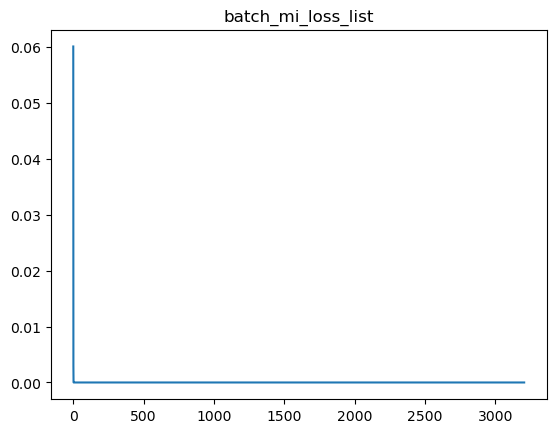

 40%|███████████████▏                      | 6408/16018 [11:44<17:36,  9.09it/s]

now batch:6408 in epoch 0


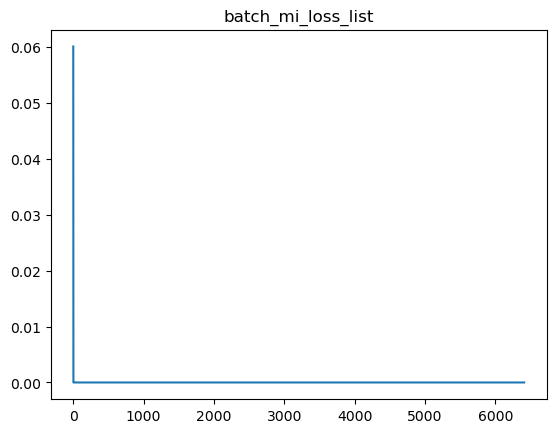

 60%|██████████████████████▊               | 9612/16018 [17:19<10:26, 10.22it/s]

now batch:9612 in epoch 0


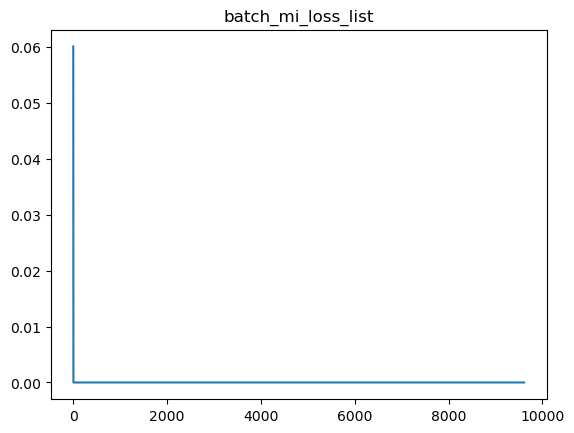

 80%|█████████████████████████████▌       | 12815/16018 [22:54<06:06,  8.73it/s]

now batch:12816 in epoch 0


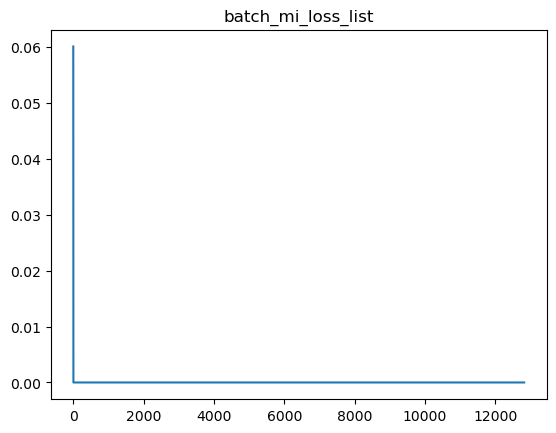

100%|█████████████████████████████████████| 16018/16018 [28:37<00:00,  9.33it/s]


============================== epoch: 0 loss: 0.06306912080617622


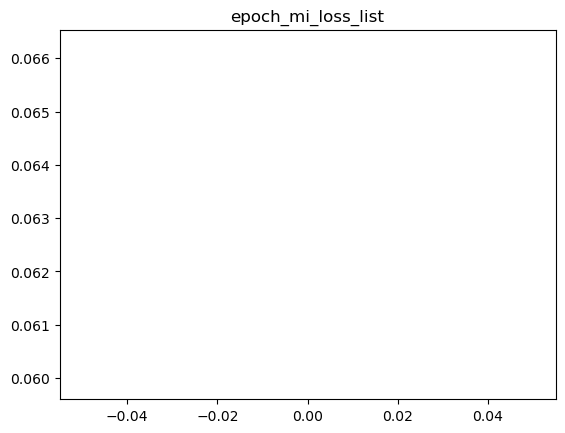

 20%|███████▌                              | 3203/16018 [05:35<20:50, 10.25it/s]

now batch:3204 in epoch 1


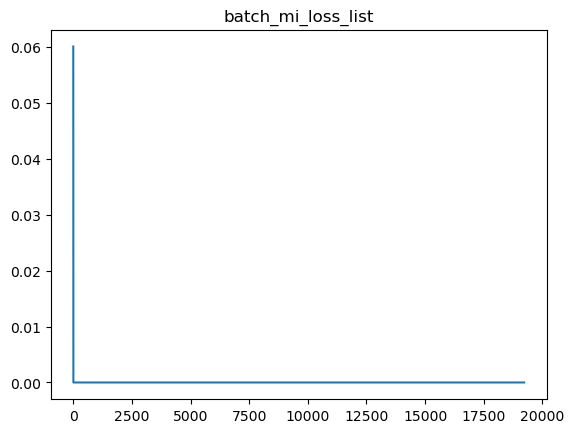

 40%|███████████████▏                      | 6408/16018 [11:10<16:38,  9.63it/s]

now batch:6408 in epoch 1


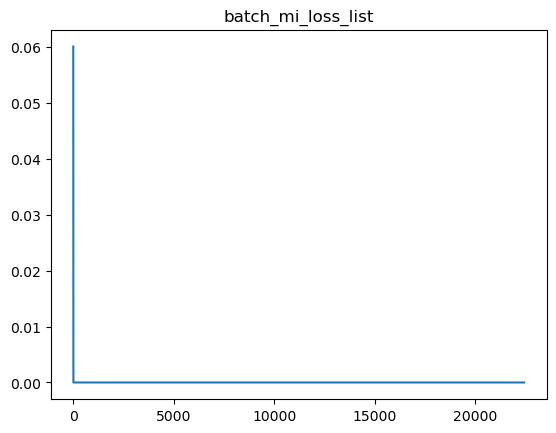

 60%|██████████████████████▊               | 9611/16018 [16:49<10:53,  9.80it/s]

now batch:9612 in epoch 1


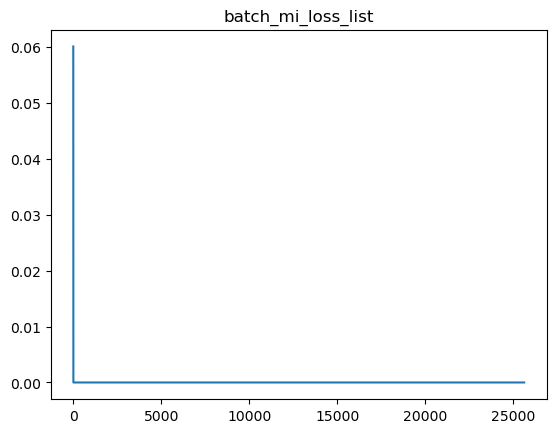

 80%|█████████████████████████████▌       | 12816/16018 [22:29<05:45,  9.28it/s]

now batch:12816 in epoch 1


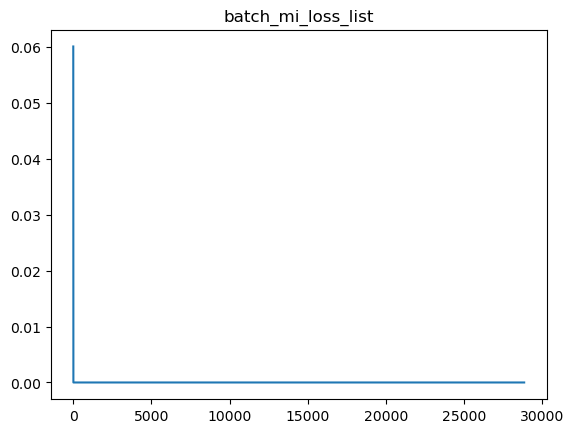

100%|█████████████████████████████████████| 16018/16018 [28:11<00:00,  9.47it/s]


============================== epoch: 1 loss: 0.0


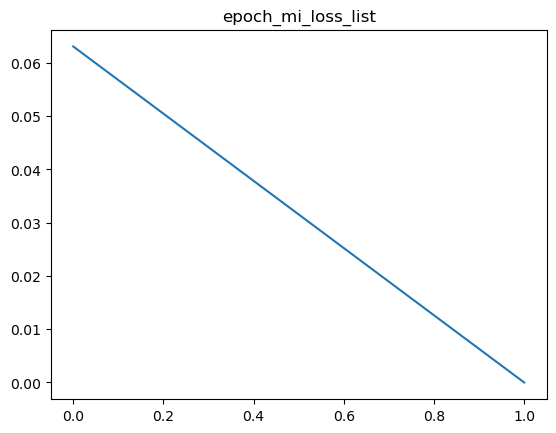

 20%|███████▌                              | 3204/16018 [05:43<21:24,  9.98it/s]

now batch:3204 in epoch 2


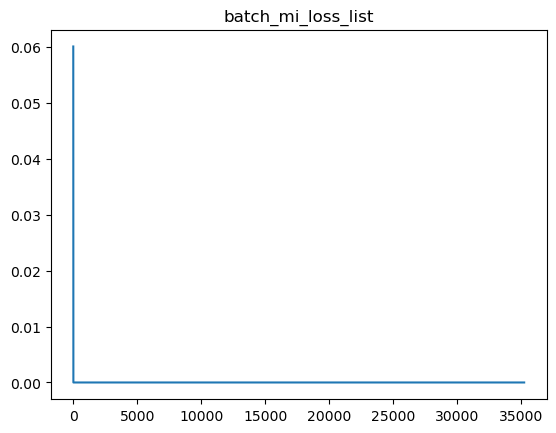

 40%|███████████████▏                      | 6408/16018 [16:13<17:38,  9.08it/s]

now batch:6408 in epoch 2


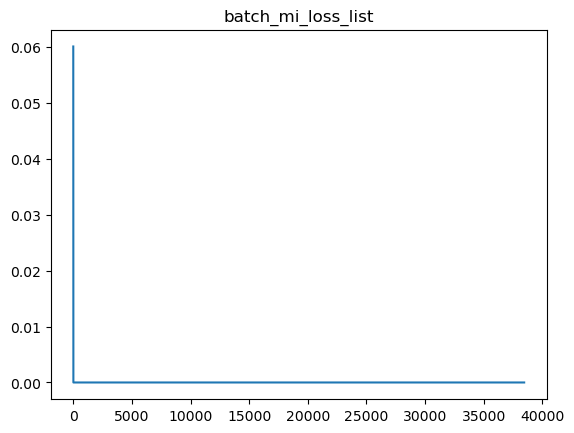

 60%|██████████████████████▊               | 9612/16018 [22:04<10:59,  9.72it/s]

now batch:9612 in epoch 2


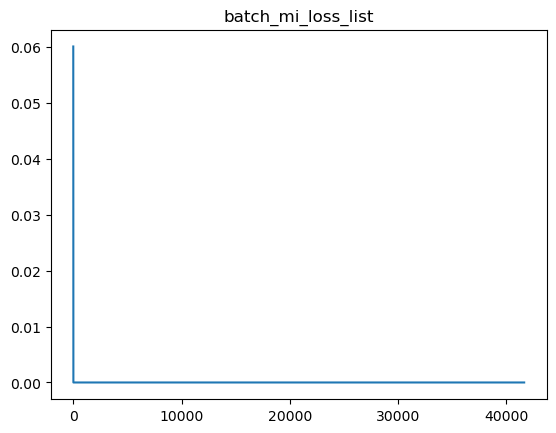

 80%|█████████████████████████████▌       | 12815/16018 [27:57<05:45,  9.28it/s]

now batch:12816 in epoch 2


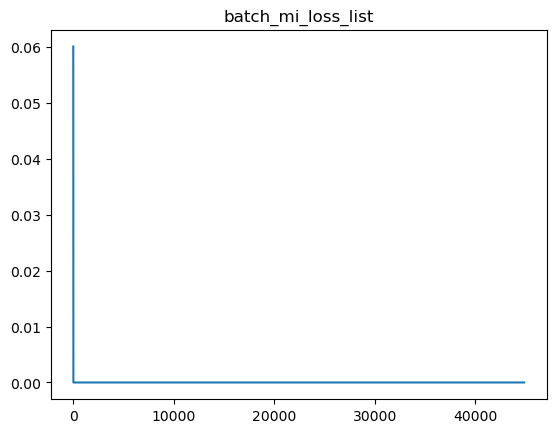

100%|█████████████████████████████████████| 16018/16018 [33:40<00:00,  7.93it/s]

============================== epoch: 2 loss: 0.0


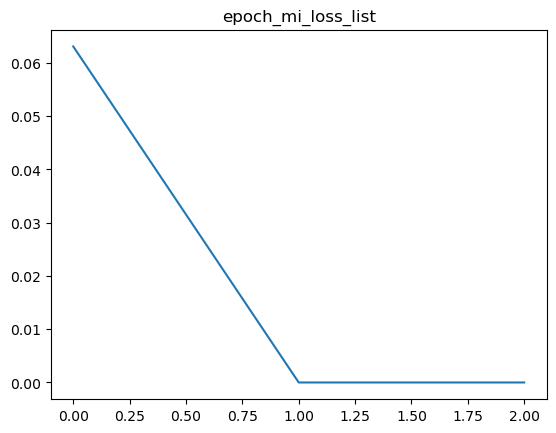

 20%|███████▌                              | 3204/16018 [05:40<23:43,  9.00it/s]

now batch:3204 in epoch 3


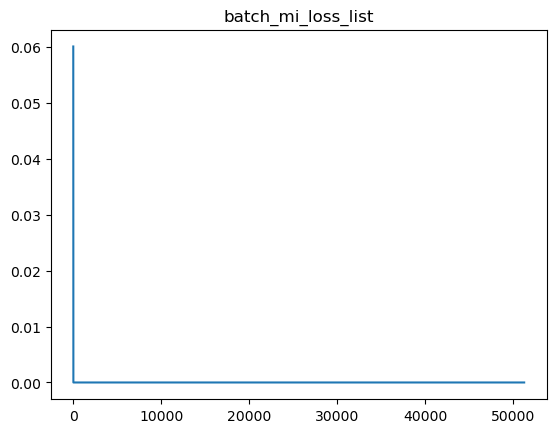

 34%|████████████▉                         | 5475/16018 [09:44<20:58,  8.38it/s]

In [ ]:
train(phase=1)

In [ ]:
train(phase=2)